# Load Libraries

In [81]:
library(MASS)
library(corrplot)

# Load Data

In [77]:
setwd("~/Downloads/Datasets/7406/Project")

white <- read.csv(file = "winequality_white.csv", head = TRUE, sep=";")
red <- read.csv(file = "winequality_red.csv", head = TRUE, sep=";")

In [78]:
white$type <- "white"
red$type <- "red"

In [80]:
#wine <- rbind(white, red)
wine <- red


# Exploratory Data Analysis

In [61]:
head(wine, 3)
str(wine)
summary(wine)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red


'data.frame':	1599 obs. of  13 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...
 $ type                : chr  "red" "red" "red" "red" ...


 fixed.acidity   volatile.acidity  citric.acid    residual.sugar  
 Min.   : 4.60   Min.   :0.1200   Min.   :0.000   Min.   : 0.900  
 1st Qu.: 7.10   1st Qu.:0.3900   1st Qu.:0.090   1st Qu.: 1.900  
 Median : 7.90   Median :0.5200   Median :0.260   Median : 2.200  
 Mean   : 8.32   Mean   :0.5278   Mean   :0.271   Mean   : 2.539  
 3rd Qu.: 9.20   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 2.600  
 Max.   :15.90   Max.   :1.5800   Max.   :1.000   Max.   :15.500  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08747   Mean   :15.87       Mean   : 46.47       Mean   :0.9967  
 3rd Qu.:0.09000   3rd Qu.:21.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61100   Max.   :72.00       Max.   :289.00       Max.   :1

In [62]:
dim(white)

[1] 4898   13

In [63]:
dim(red)

[1] 1599   13

In [64]:
dim(wine)

[1] 1599   13

In [65]:
summary(wine)

 fixed.acidity   volatile.acidity  citric.acid    residual.sugar  
 Min.   : 4.60   Min.   :0.1200   Min.   :0.000   Min.   : 0.900  
 1st Qu.: 7.10   1st Qu.:0.3900   1st Qu.:0.090   1st Qu.: 1.900  
 Median : 7.90   Median :0.5200   Median :0.260   Median : 2.200  
 Mean   : 8.32   Mean   :0.5278   Mean   :0.271   Mean   : 2.539  
 3rd Qu.: 9.20   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 2.600  
 Max.   :15.90   Max.   :1.5800   Max.   :1.000   Max.   :15.500  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08747   Mean   :15.87       Mean   : 46.47       Mean   :0.9967  
 3rd Qu.:0.09000   3rd Qu.:21.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61100   Max.   :72.00       Max.   :289.00       Max.   :1

In [66]:
na_count <- sapply(wine, function(y) sum(length(which(is.na(y)))))
na_count

fixed.acidity     volatile.acidity          citric.acid 
                   0                    0                    0 
      residual.sugar            chlorides  free.sulfur.dioxide 
                   0                    0                    0 
total.sulfur.dioxide              density                   pH 
                   0                    0                    0 
           sulphates              alcohol              quality 
                   0                    0                    0 
                type 
                   0

Our dataset does not have any missing values. 

Our response variable "Quality" is a categorical one with the ranks from 1 to 10.
The range of values (min/max) across the variables does not require scaling or normalization. All predictors are numerical.


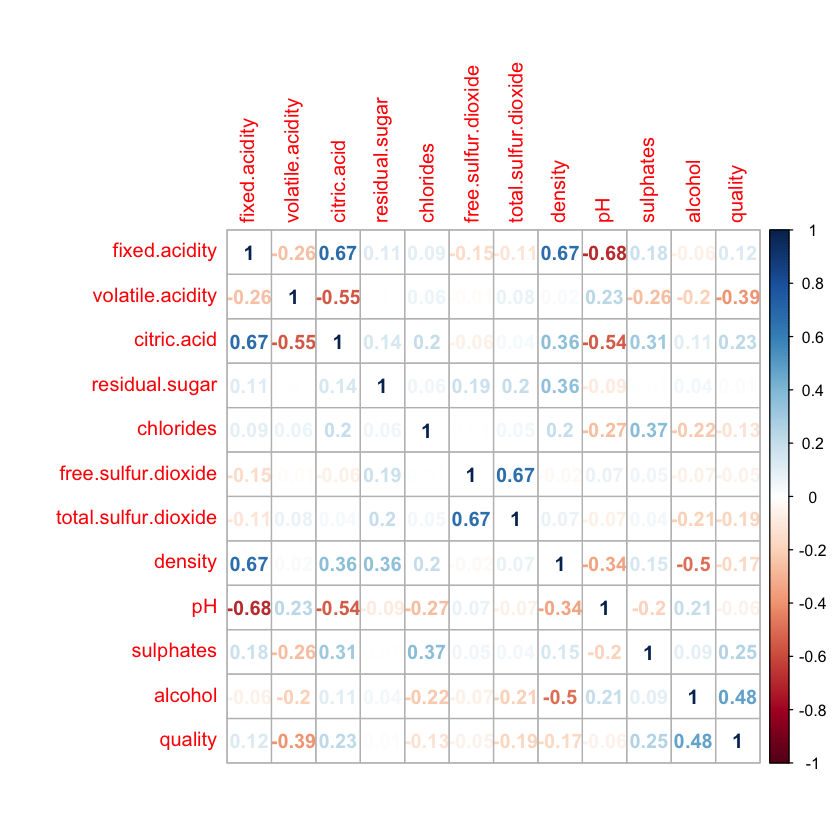

In [67]:
corrplot(cor(wine[1:(length(wine)-1)]), method="number")

Covariance Matrix

There is some significant multicollineraity between several variables:

density - alcohol
total.sulfur.dioxide - free.sulfur.dioxide
density - residual.sugar
residual.sugar - total.sulfur.dioxide
density - fixed.acidity

Certain predictors will have to be removed. Most likely candidates are:

free.sulfur.dioxide
residual.sugar
fixed.acidity
alcohol


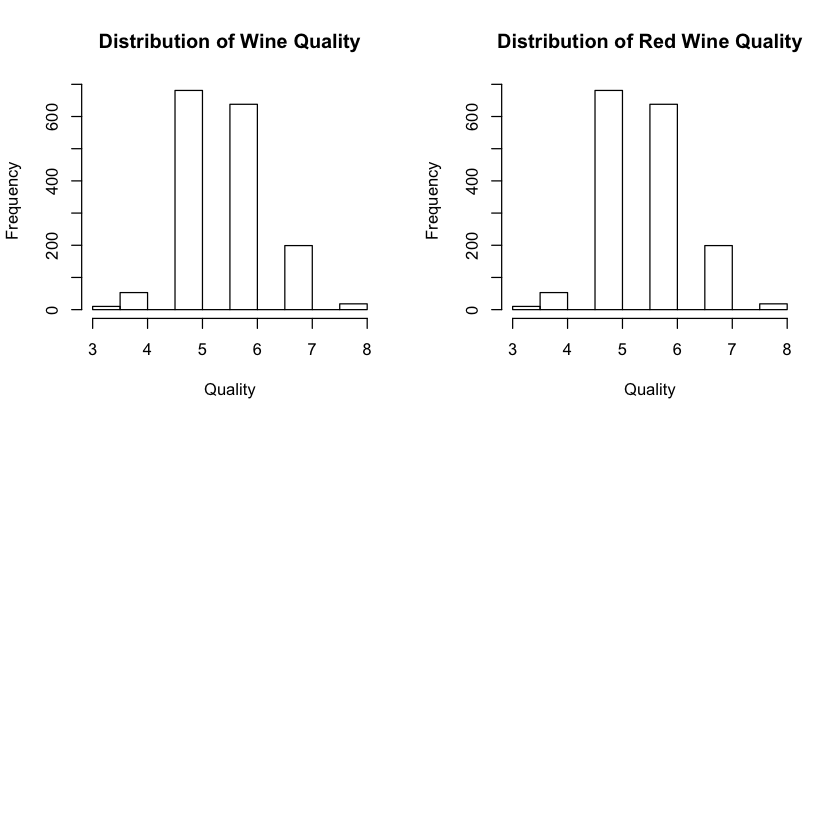

In [68]:
par(mfrow = c(2,2))

hist(wine$quality,xlab = 'Quality', main = "Distribution of Wine Quality")
#hist(wine[wine$type == "white",]$quality,xlab = 'Quality', main = "Distribution of White Wine Quality")
hist(wine[wine$type == "red",]$quality,xlab = 'Quality', main = "Distribution of Red Wine Quality")

The following objects are masked from wine (pos = 3):

    alcohol, chlorides, citric.acid, density, fixed.acidity,
    free.sulfur.dioxide, pH, quality, residual.sugar, sulphates,
    total.sulfur.dioxide, type, volatile.acidity



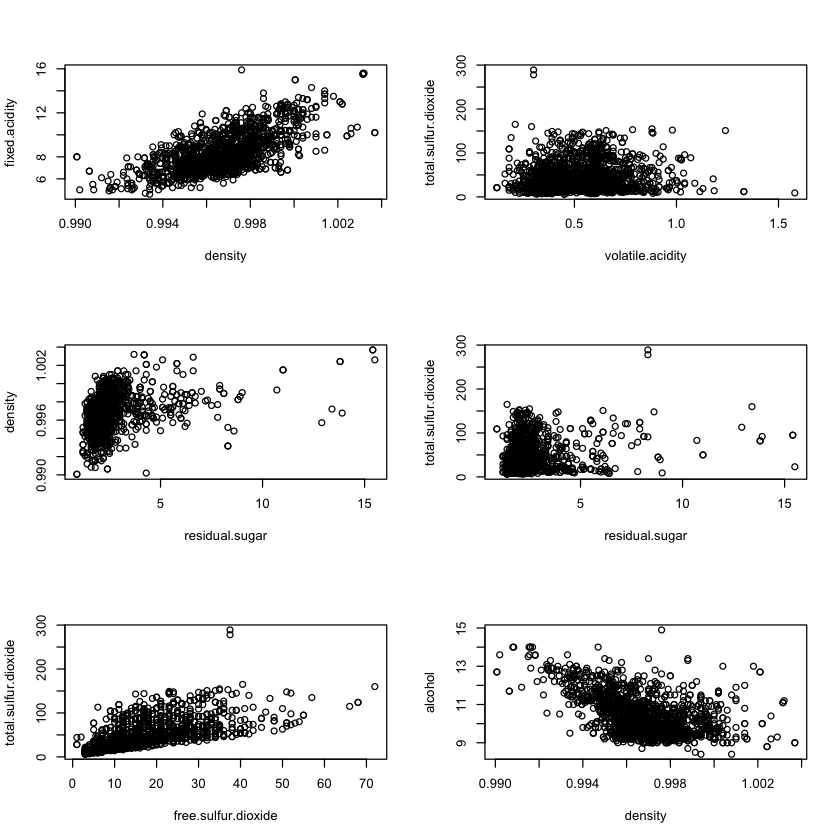

In [69]:
attach(wine)
par(mfrow = c(3,2))

plot(density, fixed.acidity)
plot(volatile.acidity, total.sulfur.dioxide)
plot(residual.sugar, density)
plot(residual.sugar, total.sulfur.dioxide)
plot(free.sulfur.dioxide, total.sulfur.dioxide)
plot(density, alcohol)

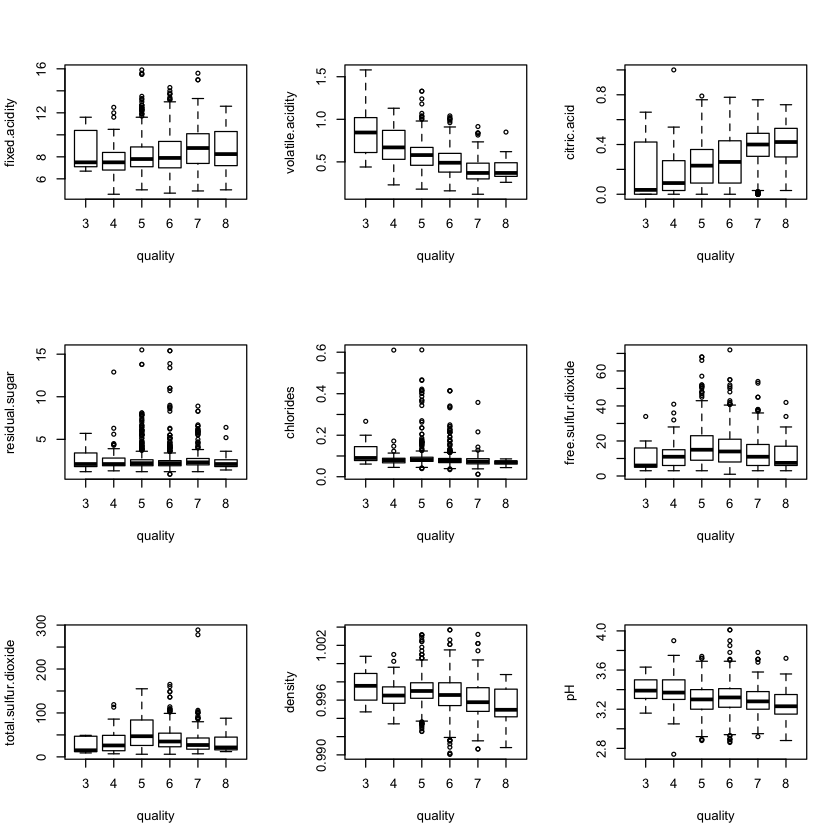

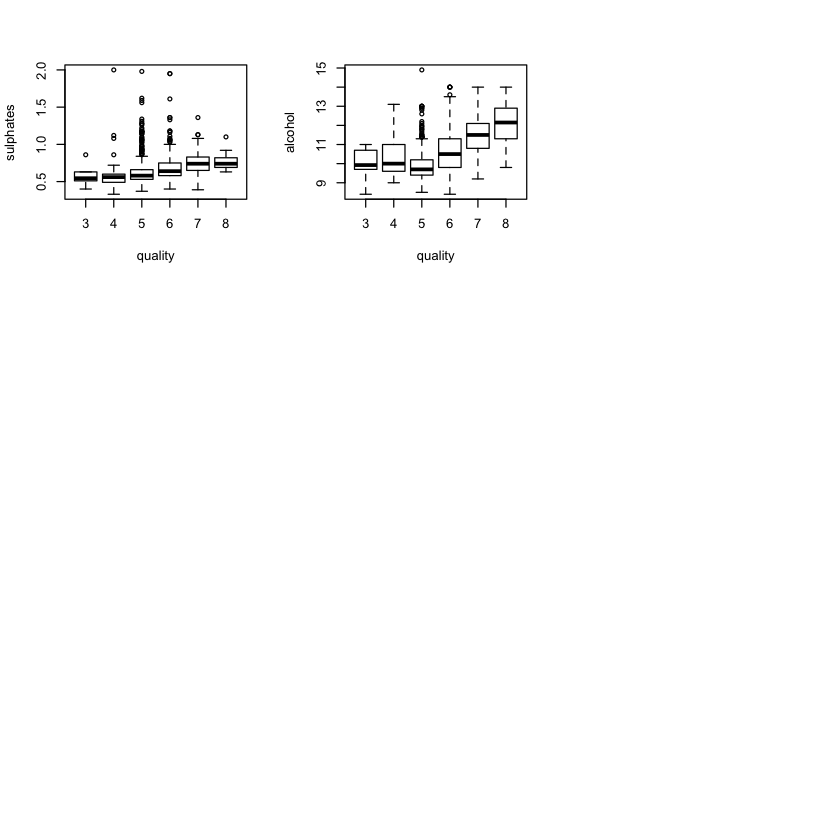

In [70]:
par(mfrow = c(3,3))
boxplot(fixed.acidity ~ quality)
boxplot(volatile.acidity ~ quality)
boxplot(citric.acid ~ quality)
boxplot(residual.sugar ~ quality)
boxplot(chlorides ~ quality)
boxplot(free.sulfur.dioxide ~ quality)
boxplot(total.sulfur.dioxide ~ quality)
boxplot(density ~ quality)
boxplot(pH ~ quality)
boxplot(sulphates ~ quality)
boxplot(alcohol ~ quality)

In [82]:
# We need to reduce the number of classes in our response variable to acive a better accuracy

#wine$quality <- as.numeric(wine$quality)
wine$quality[wine$quality=="1"] <- "Low Quality" 
wine$quality[wine$quality=="2"] <- "Low Quality" 
wine$quality[wine$quality=="3"] <- "Low Quality"
wine$quality[wine$quality=="4"] <- "Low Quality" 
wine$quality[wine$quality=="5"] <- "Medium Quality" 
wine$quality[wine$quality=="6"] <- "Medium Quality" 
wine$quality[wine$quality=="7"] <- "Medium Quality" 
wine$quality[wine$quality=="8"] <- "High Quality" 
wine$quality[wine$quality=="9"] <- "High Quality"
wine$quality[wine$quality=="10"] <- "High Quality"

wine$quality <- as.factor(wine$quality)

head(wine)
summary(wine)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,Medium Quality,red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,Medium Quality,red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,Medium Quality,red
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,Medium Quality,red
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,Medium Quality,red
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,Medium Quality,red


 fixed.acidity   volatile.acidity  citric.acid    residual.sugar  
 Min.   : 4.60   Min.   :0.1200   Min.   :0.000   Min.   : 0.900  
 1st Qu.: 7.10   1st Qu.:0.3900   1st Qu.:0.090   1st Qu.: 1.900  
 Median : 7.90   Median :0.5200   Median :0.260   Median : 2.200  
 Mean   : 8.32   Mean   :0.5278   Mean   :0.271   Mean   : 2.539  
 3rd Qu.: 9.20   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 2.600  
 Max.   :15.90   Max.   :1.5800   Max.   :1.000   Max.   :15.500  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08747   Mean   :15.87       Mean   : 46.47       Mean   :0.9967  
 3rd Qu.:0.09000   3rd Qu.:21.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61100   Max.   :72.00       Max.   :289.00       Max.   :1

# Modelling

### Ordinal Regression

In [83]:
# Ordinal Regression

ord_mod <- polr(quality ~. - type, data = wine, Hess = TRUE)
summary(ord_mod)


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [16]:
(ctable <- coef(summary(ord_mod)))

,Value,Std. Error,t value
fixed.acidity,2.417063e-01,0.0275648890,8.7686280
volatile.acidity,-4.072036e+00,0.2269082346,-17.9457374
citric.acid,-1.892841e-01,0.2093307596,-0.9042347
residual.sugar,1.628154e-01,0.0064176227,25.3700524
chlorides,-1.985618e+00,0.8913076682,-2.2277579
free.sulfur.dioxide,1.549693e-02,0.0020949328,7.3973424
total.sulfur.dioxide,-4.457698e-03,0.0008492552,-5.2489498
density,-2.757579e+02,0.4215452626,-654.1596248
pH,1.437609e+00,0.1915694379,7.5043778
sulphates,2.008337e+00,0.1955731253,10.2689821


In [17]:
## calculate and store p values
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2

## combined table
(ctable <- cbind(ctable, "p value" = p))

,Value,Std. Error,t value,p value
fixed.acidity,2.417063e-01,0.0275648890,8.7686280,1.808564e-18
volatile.acidity,-4.072036e+00,0.2269082346,-17.9457374,5.181814e-72
citric.acid,-1.892841e-01,0.2093307596,-0.9042347,3.658710e-01
residual.sugar,1.628154e-01,0.0064176227,25.3700524,5.399982e-142
chlorides,-1.985618e+00,0.8913076682,-2.2277579,2.589666e-02
free.sulfur.dioxide,1.549693e-02,0.0020949328,7.3973424,1.389370e-13
total.sulfur.dioxide,-4.457698e-03,0.0008492552,-5.2489498,1.529688e-07
density,-2.757579e+02,0.4215452626,-654.1596248,0.000000e+00
pH,1.437609e+00,0.1915694379,7.5043778,6.172105e-14
sulphates,2.008337e+00,0.1955731253,10.2689821,9.722501e-25


In [18]:
(ci <- confint(ord_mod)) # default method gives profiled CIs

Waiting for profiling to be done...


,2.5 %,97.5 %
fixed.acidity,0.155384963,0.328540327
volatile.acidity,-4.517687424,-3.628131855
citric.acid,-0.599701772,0.221013148
residual.sugar,NA,NA
chlorides,-3.738391480,-0.242069397
free.sulfur.dioxide,0.011394941,0.019607264
total.sulfur.dioxide,-0.006123128,-0.002795846
density,NA,NA
pH,0.953364628,1.921475846
sulphates,1.611607701,2.406659113


In [19]:
confint.default(ord_mod) # CIs assuming normality

# If the move from 2.5% to 97.% includes a zero (a sign change) then this coefficient is NOT statistically significant

,2.5 %,97.5 %
fixed.acidity,1.876801e-01,2.957324e-01
volatile.acidity,-4.516768e+00,-3.627304e+00
citric.acid,-5.995649e-01,2.209966e-01
residual.sugar,1.502371e-01,1.753937e-01
chlorides,-3.732549e+00,-2.386868e-01
free.sulfur.dioxide,1.139094e-02,1.960293e-02
total.sulfur.dioxide,-6.122207e-03,-2.793188e-03
density,-2.765841e+02,-2.749317e+02
pH,1.062140e+00,1.813079e+00
sulphates,1.625021e+00,2.391653e+00


In [20]:
## odds ratios - These coefficients are called proportional odds ratios
exp(cbind(OR = coef(ord_mod), ci))

,OR,2.5 %,97.5 %
fixed.acidity,1.273420e+00,1.16810755,1.38893925
volatile.acidity,1.704266e-02,0.01091423,0.02656577
citric.acid,8.275513e-01,0.54897533,1.24733983
residual.sugar,1.176819e+00,NA,NA
chlorides,1.372958e-01,0.02379234,0.78500170
free.sulfur.dioxide,1.015618e+00,1.01146011,1.01980075
total.sulfur.dioxide,9.955522e-01,0.99389558,0.99720806
density,1.737279e-120,NA,NA
pH,4.210618e+00,2.59442426,6.83103258
sulphates,7.450916e+00,5.01086072,11.09682591


In [21]:
# Let's rerun the regression with only significant predictors

ord_mods <- polr(as.factor(quality) ~. -citric.acid - chlorides - total.sulfur.dioxide, data = wine, Hess = TRUE)
summary(ord_mods)


Call:
polr(formula = as.factor(quality) ~ . - citric.acid - chlorides - 
    total.sulfur.dioxide, data = wine, Hess = TRUE)

Coefficients:
                         Value Std. Error  t value
fixed.acidity        2.648e-01   0.025371   10.438
volatile.acidity    -4.219e+00   0.210855  -20.011
residual.sugar       1.775e-01   0.006316   28.110
free.sulfur.dioxide  9.002e-03   0.001713    5.255
density             -3.262e+02   0.409558 -796.352
pH                   1.624e+00   0.188586    8.610
sulphates            1.845e+00   0.189289    9.749
alcohol              5.949e-01   0.025216   23.593
typewhite           -1.312e+00   0.103327  -12.702

Intercepts:
    Value     Std. Error t value  
3|4 -317.3814    0.4155  -763.7824
4|5 -315.1761    0.4143  -760.6645
5|6 -311.9969    0.4178  -746.7721
6|7 -309.3974    0.4260  -726.3517
7|8 -307.0611    0.4348  -706.2572
8|9 -303.2989    0.6203  -488.9429

Residual Deviance: 14164.56 
AIC: 14194.56 

In [22]:
(ctable1 <- coef(summary(ord_mods)))

,Value,Std. Error,t value
fixed.acidity,0.26483105,0.025370891,10.438382
volatile.acidity,-4.21933618,0.210854722,-20.010632
residual.sugar,0.17754025,0.006315920,28.109959
free.sulfur.dioxide,0.00900195,0.001713003,5.255068
density,-326.15235173,0.409558270,-796.351522
pH,1.62367412,0.188585719,8.609741
sulphates,1.84537821,0.189289194,9.748989
alcohol,0.59492704,0.025216267,23.592986
typewhite,-1.31249246,0.103326782,-12.702345
3|4,-317.38136570,0.415538999,-763.782381


In [23]:
## calculate and store p values
p <- pnorm(abs(ctable1[, "t value"]), lower.tail = FALSE) * 2

## combined table
(ctable1 <- cbind(ctable1, "p value" = p))

,Value,Std. Error,t value,p value
fixed.acidity,0.26483105,0.025370891,10.438382,1.656092e-25
volatile.acidity,-4.21933618,0.210854722,-20.010632,4.449744e-89
residual.sugar,0.17754025,0.006315920,28.109959,7.401959e-174
free.sulfur.dioxide,0.00900195,0.001713003,5.255068,1.479697e-07
density,-326.15235173,0.409558270,-796.351522,0.000000e+00
pH,1.62367412,0.188585719,8.609741,7.322607e-18
sulphates,1.84537821,0.189289194,9.748989,1.863150e-22
alcohol,0.59492704,0.025216267,23.592986,4.549167e-123
typewhite,-1.31249246,0.103326782,-12.702345,5.738384e-37
3|4,-317.38136570,0.415538999,-763.782381,0.000000e+00


In [24]:
(ci1 <- confint(ord_mods)) # default method gives profiled CIs

Waiting for profiling to be done...


,2.5 %,97.5 %
fixed.acidity,0.18034160,0.3497219
volatile.acidity,-4.63357327,-3.8069569
residual.sugar,NA,NA
free.sulfur.dioxide,0.00564639,0.0123613
density,NA,NA
pH,1.14802731,2.1008697
sulphates,1.45741729,2.2371809
alcohol,0.49179716,0.6976887
typewhite,-1.57096278,-1.0549920


In [25]:
ci1 <- confint.default(ord_mods) # CIs assuming normality
ci1

# All predictors are significant

,2.5 %,97.5 %
fixed.acidity,2.151050e-01,0.31455708
volatile.acidity,-4.632604e+00,-3.80606852
residual.sugar,1.651613e-01,0.18991923
free.sulfur.dioxide,5.644525e-03,0.01235937
density,-3.269551e+02,-325.34963227
pH,1.254053e+00,1.99329534
sulphates,1.474378e+00,2.21637822
alcohol,5.455041e-01,0.64435002
typewhite,-1.515009e+00,-1.10997569


In [26]:
## odds ratios - These coefficients are called proportional odds ratios
exp(cbind(OR = coef(ord_mods), ci1))

,OR,2.5 %,97.5 %
fixed.acidity,1.303211e+00,1.239992e+00,1.369653e+00
volatile.acidity,1.470841e-02,9.729392e-03,2.223543e-02
residual.sugar,1.194276e+00,1.179583e+00,1.209152e+00
free.sulfur.dioxide,1.009043e+00,1.005660e+00,1.012436e+00
density,2.258569e-142,1.012084e-142,5.040226e-142
pH,5.071690e+00,3.504518e+00,7.339681e+00
sulphates,6.330494e+00,4.368319e+00,9.174044e+00
alcohol,1.812899e+00,1.725478e+00,1.904749e+00
typewhite,2.691484e-01,2.198062e-01,3.295670e-01


In [27]:
# Proportional Odds

sf <- function(y) {
  c('Y>=0' = qlogis(mean(y >= 0)),
    'Y>=1' = qlogis(mean(y >= 1)),
    'Y>=2' = qlogis(mean(y >= 2)),
    'Y>=3' = qlogis(mean(y >= 3)),
    'Y>=4' = qlogis(mean(y >= 4)),
    'Y>=6' = qlogis(mean(y >= 6)),
    'Y>=7' = qlogis(mean(y >= 7)),
    'Y>=8' = qlogis(mean(y >= 8)),
    'Y>=9' = qlogis(mean(y >= 9)))
}

(s <- with(wine, summary(as.numeric(quality) ~ fixed.acidity + volatile.acidity + residual.sugar + 
                           free.sulfur.dioxide + density + pH + sulphates + alcohol, fun=sf)))

 Length   Class    Mode 
      3 formula    call 

In [28]:
# Example

glm(I(as.numeric(quality) >= 4) ~ density, family ="binomial", data = wine)


Call:  glm(formula = I(as.numeric(quality) >= 4) ~ density, family = "binomial", 
    data = wine)

Coefficients:
(Intercept)      density  
      94.83       -89.89  

Degrees of Freedom: 6496 Total (i.e. Null);  6495 Residual
Null Deviance:	    382.5 
Residual Deviance: 379.4 	AIC: 383.4

In [30]:
#s[, 4] <- s[, 4] - s[, 3]
#s[, 3] <- s[, 3] - s[, 3]
#s

In [31]:
glm(I(as.numeric(quality) >= 6) ~ density, family ="binomial", data = wine)


Call:  glm(formula = I(as.numeric(quality) >= 6) ~ density, family = "binomial", 
    data = wine)

Coefficients:
(Intercept)      density  
      202.7       -203.2  

Degrees of Freedom: 6496 Total (i.e. Null);  6495 Residual
Null Deviance:	    8541 
Residual Deviance: 8048 	AIC: 8052

### Linear Regression

In [32]:
# Linear Regression

set.seed(6501)

nobs <- nrow(wine)
spl <- 0.8

shuffle_index <- sample(1:nobs)
wine <- wine[shuffle_index, ]

train_indices = sample(1:nobs, nobs * spl)

train = wine[train_indices,] 
test = wine[-train_indices,]

mod1 = lm(quality ~. - chlorides - total.sulfur.dioxide ,data = train) 
summary(mod1)

kv <- 9
ad <- 2*kv*(kv+1)/(nrow(train)-kv-1)
aic_ad1 <- round(AIC(mod1) + ad,1)
bic1 <- round(BIC(mod1),1)

print(paste('AIC = ', aic_ad1, '   BIC = ', bic1))


Call:
lm(formula = quality ~ . - chlorides - total.sulfur.dioxide, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7449 -0.4698 -0.0449  0.4606  3.0309 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.566e+02  1.720e+01   9.104  < 2e-16 ***
fixed.acidity        1.264e-01  1.835e-02   6.889 6.27e-12 ***
volatile.acidity    -1.504e+00  8.911e-02 -16.874  < 2e-16 ***
citric.acid         -9.954e-02  8.747e-02  -1.138    0.255    
residual.sugar       8.005e-02  6.948e-03  11.521  < 2e-16 ***
free.sulfur.dioxide  3.208e-03  7.045e-04   4.554 5.40e-06 ***
density             -1.564e+02  1.742e+01  -8.979  < 2e-16 ***
pH                   6.342e-01  1.027e-01   6.175 7.14e-10 ***
sulphates            6.946e-01  8.406e-02   8.263  < 2e-16 ***
alcohol              1.812e-01  2.219e-02   8.162 4.10e-16 ***
typewhite           -5.405e-01  5.606e-02  -9.642  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 

[1] "AIC =  11603.3    BIC =  11682"
